In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from Modules.SphericalM import *
from Modules.SphericalV import *
from Modules.SphericalC import *

## Graph

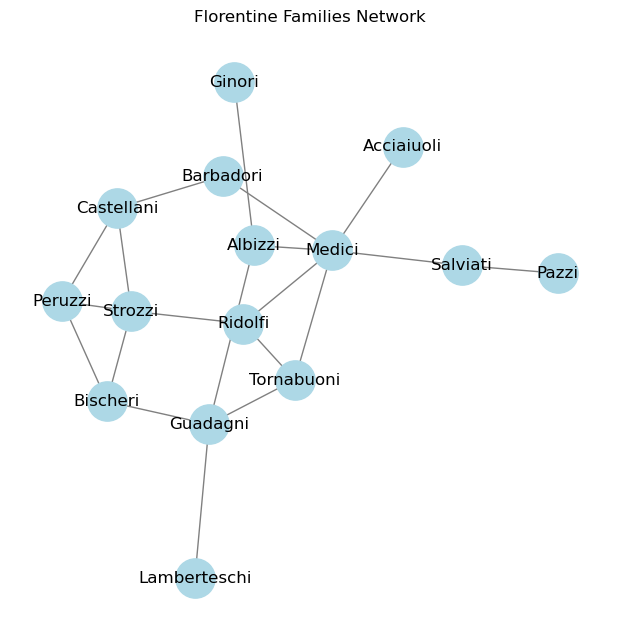

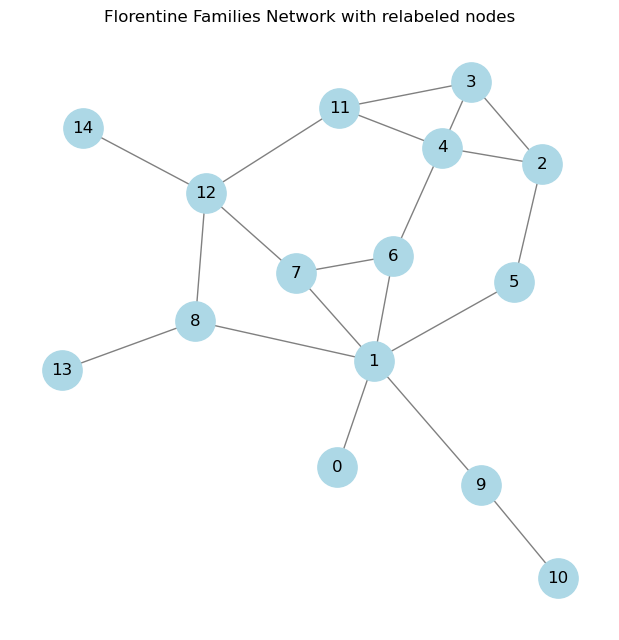

Map from original nodes to new nodes:
{'Acciaiuoli': 0, 'Medici': 1, 'Castellani': 2, 'Peruzzi': 3, 'Strozzi': 4, 'Barbadori': 5, 'Ridolfi': 6, 'Tornabuoni': 7, 'Albizzi': 8, 'Salviati': 9, 'Pazzi': 10, 'Bischeri': 11, 'Guadagni': 12, 'Ginori': 13, 'Lamberteschi': 14}


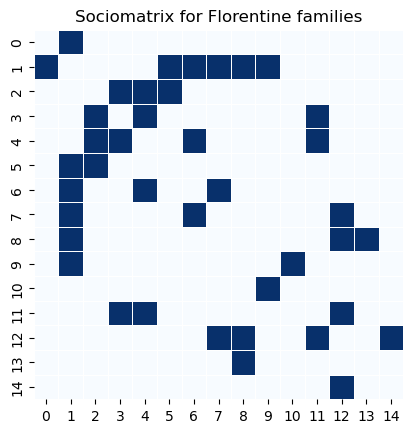

In [2]:
G = nx.florentine_families_graph()

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network")
plt.show()

G = nx.florentine_families_graph()
node_mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, node_mapping)

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network with relabeled nodes")
plt.show()
print("Map from original nodes to new nodes:")
print(node_mapping)

Y = nx.to_numpy_array(G, dtype=float)

sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("Sociomatrix for Florentine families")
plt.show()

# Latent space

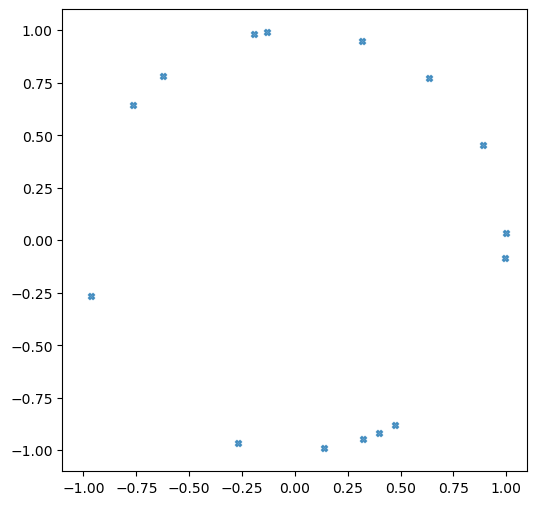

In [3]:
n = len(G.nodes)

angles = 2*np.pi*np.random.rand(n)
Z_init_r = np.stack((np.cos(angles), np.sin(angles)), axis=1)

plt.figure(figsize=(6,6))
plt.scatter(Z_init_r[:, 0], Z_init_r[:, 1], s=20, alpha=0.7,marker="X")
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.show()

## Searching MLE

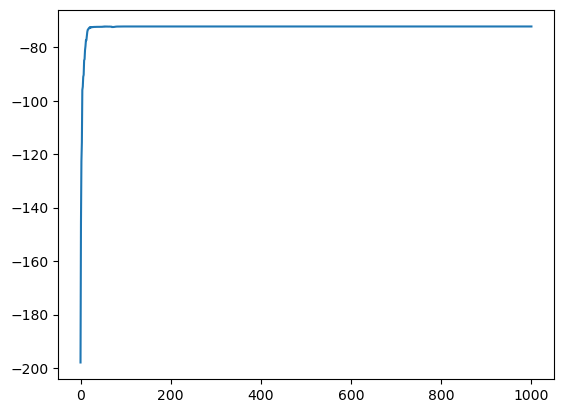

Initial log-likelihood: -197.9560794875656
Final log-likelihood: -72.17250257215656
Final alpha: -2.2161937032163515
Final beta: 2.709274022968161


In [4]:
angles_rand = 2*np.pi*np.random.rand(n)
Z_init_MLE = np.stack((np.cos(angles_rand), np.sin(angles_rand)), axis=1)
a_init_MLE = np.random.randn()
b_init_MLE = np.random.randn()
Z_ML, a_ML,b_ML, historyZ, historya, historyb  =  SearchingMLE(G, Z_init_MLE ,a_init_MLE,b_init_MLE,1000)
plt.plot([loglikelihood(G, historyZ[t],historya[t],historyb[t]) for t in range(len(historya))])
plt.show()

print("Initial log-likelihood:", loglikelihood(G,Z_init_MLE,a_init_MLE,b_init_MLE))
print("Final log-likelihood:", loglikelihood(G,Z_ML,a_ML,b_ML))
print("Final alpha:", a_ML)
print("Final beta:", b_ML)

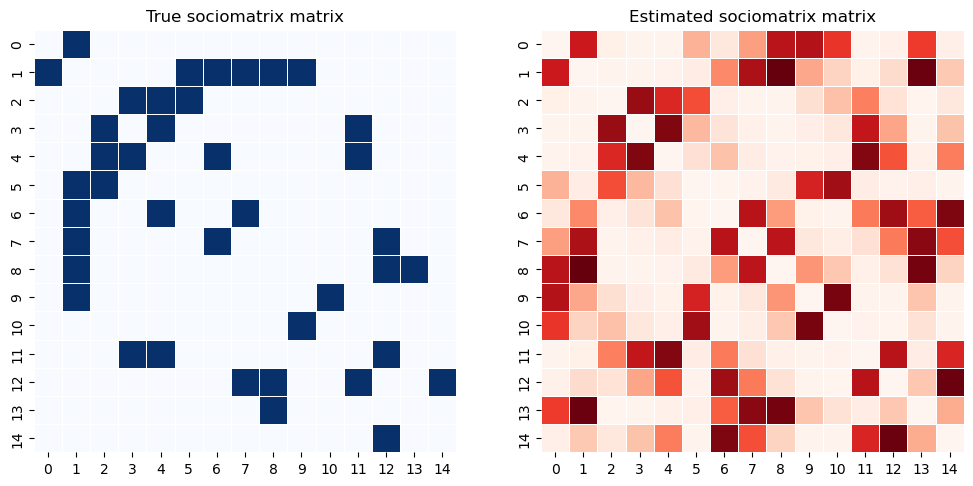

In [ ]:
Y_ML = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            d = Z_ML[i].T @ Z_ML[j]
            Y_ML[i,j] = expit(a_ML + b_ML*d)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.heatmap(nx.to_numpy_array(G, dtype=int), annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(1,2,2)
sns.heatmap(Y_ML, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("Estimated sociomatrix matrix")
plt.show()

## Searching posterior distribution: HMC Algorithm

In [7]:
# Execute HMC
number_of_samples = 50
Z_init = Z_ML.copy()
a_init = a_ML
b_init = b_ML


print("Log-L MLE:", loglikelihood(G,Z_ML,a_ML,b_ML))
print("Log-L starter:", loglikelihood(G,Z_init,a_init,b_init))

samples_Z, samples_a, samples_b, Hp, LogLp, acep_rate_history = ghmc(G, Z_init, a_init, b_init, number_of_samples, epsilon_init=0.05, 
                                                                     std_dev_init=0.04, std_dev_init_a = 1.0, std_dev_init_b = 1.0, 
                                                                     percentage_warmup=0.1)
samples_Z = [compute_starS1(samples_Z[i],Z_ML) for i in range(len(samples_Z))]
samples_Z = np.array(samples_Z)
# Estimators
## CM
from scipy.stats import circmean
angles_CM = circmean(np.arctan2(samples_Z[:, :, 1], samples_Z[:, :, 0]), high=2*np.pi, low=0,axis=0)
Z_CM =  np.stack((np.cos(angles_CM), np.sin(angles_CM)), axis=1)
a_CM = np.mean(samples_a, axis=0)
b_CM = np.mean(samples_b, axis=0)
## MAP
Z_MAP = samples_Z[np.argmin(Hp),:,:]
a_MAP = samples_a[np.argmin(Hp)]
b_MAP = samples_b[np.argmin(Hp)]


print("Log-L MAP:", loglikelihood(G,Z_MAP,a_MAP,b_MAP))
print("Log-L CM:", loglikelihood(G,Z_CM,a_CM,b_CM))

Log-L MLE: -72.17250257215656
Log-L starter: -72.17250257215656
Number of samples: 50
Number of parameters: 17
Number of iterations: 55
Number of warmup iterations: 5


 11%|█         | 6/55 [00:01<00:10,  4.49it/s]

Final parameters: epsilon=0.0500, L=20, std_dev=0.0416, std_dev_a=1.0000, std_dev_b=1.0000


100%|██████████| 55/55 [00:12<00:00,  4.34it/s]

Acceptance rate: 0.94866
Log-L MAP: -67.81310674442294
Log-L CM: -68.0621061060182


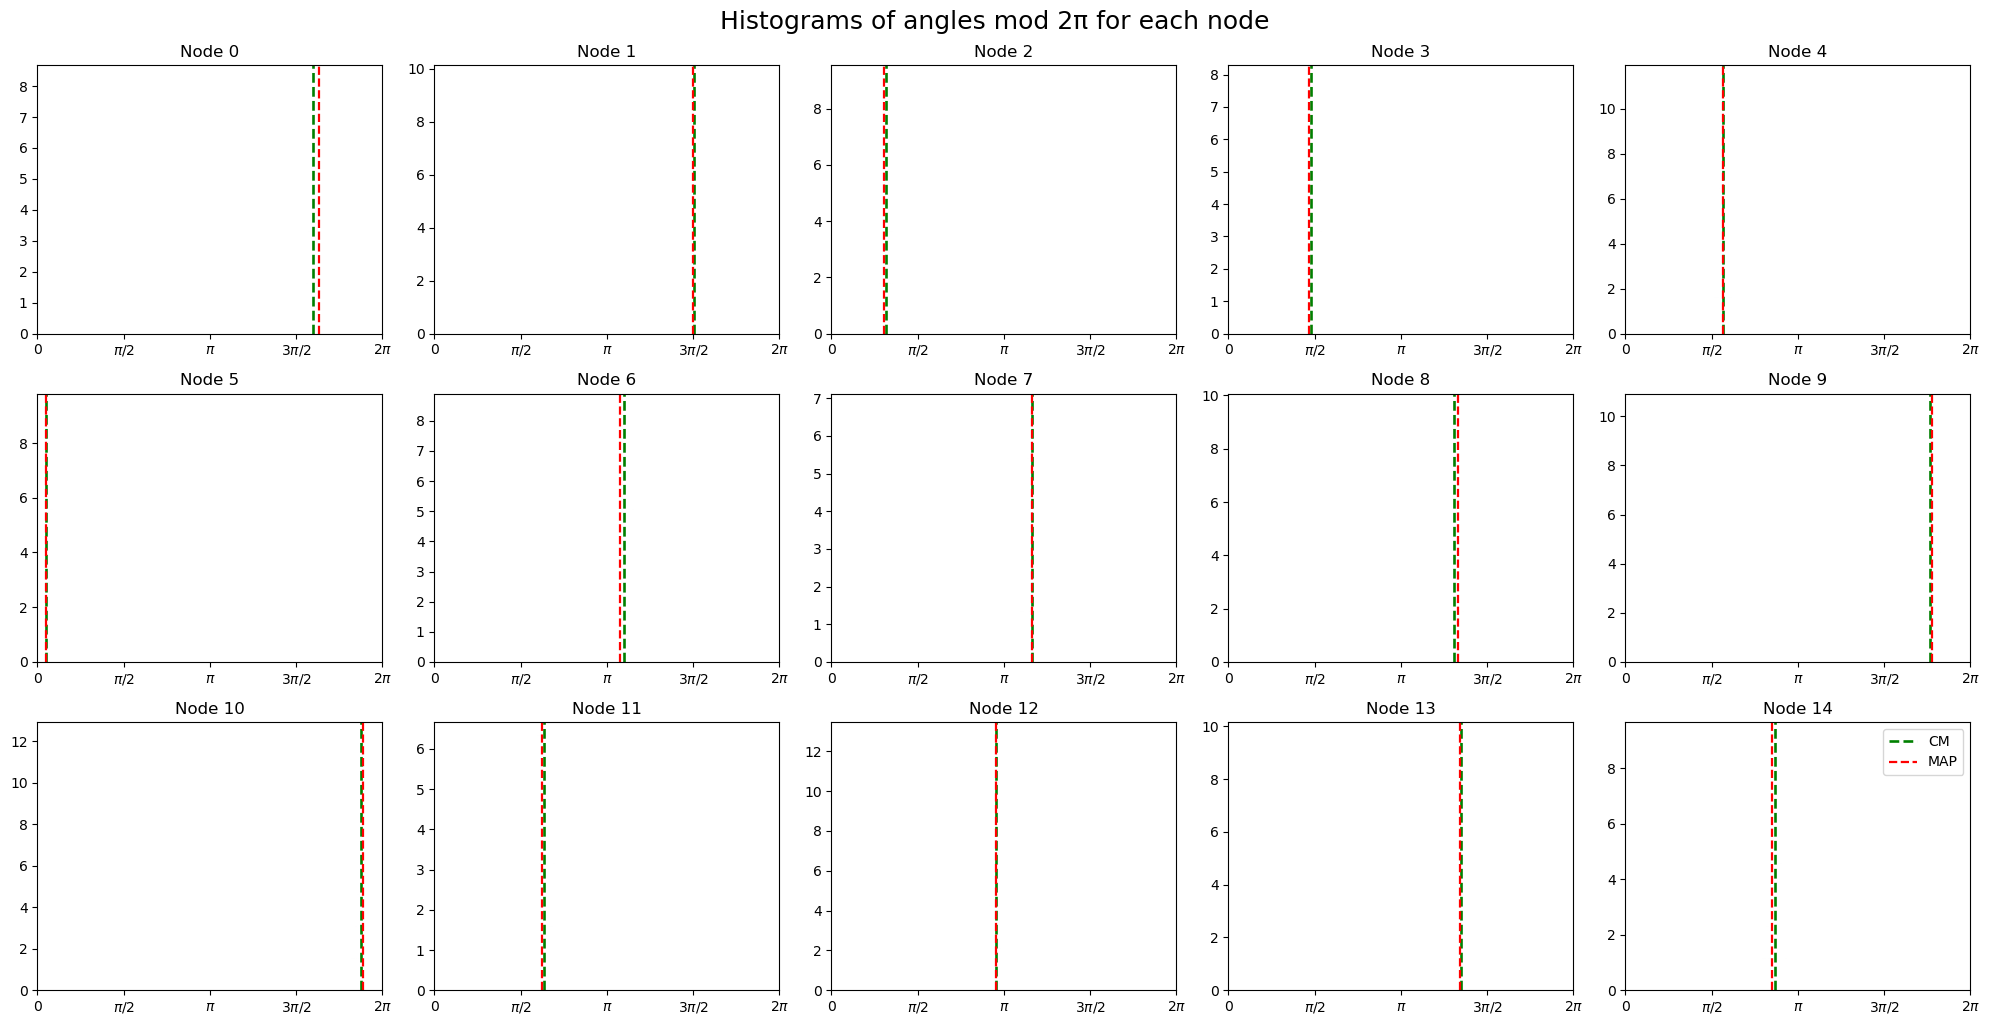

In [8]:
fig, axes = plt.subplots(3, 5, figsize=(20, 10)) 
axes = axes.flatten() 

for i in range(n):
    ax = axes[i]
    angles = np.mod(np.arctan2(samples_Z[:, i, 1], samples_Z[:, i, 0]), 2*np.pi)
    
    ax.hist(angles, bins=25, color='lightgray', edgecolor='white', density=True)
    ax.axvline(np.mod(np.arctan2(Z_CM[i, 1], Z_CM[i, 0]), 2*np.pi), color='green', linestyle='dashed', linewidth=1.9)
    ax.axvline(np.mod(np.arctan2(Z_MAP[i, 1], Z_MAP[i, 0]), 2*np.pi), color='red', linestyle='dashed', linewidth=1.6)
    ax.set_title(f'Node {i}')
    ax.set_xticks([0, np.pi/2, np.pi , 3*np.pi/2, 2*np.pi])
    ax.set_xticklabels(['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$',r'$2\pi$'])
    ax.grid(False)
plt.legend(['CM','MAP'], loc='upper right')
plt.tight_layout()
plt.suptitle("Histograms of angles mod 2π for each node", y=1.02, fontsize=18) 
plt.show()

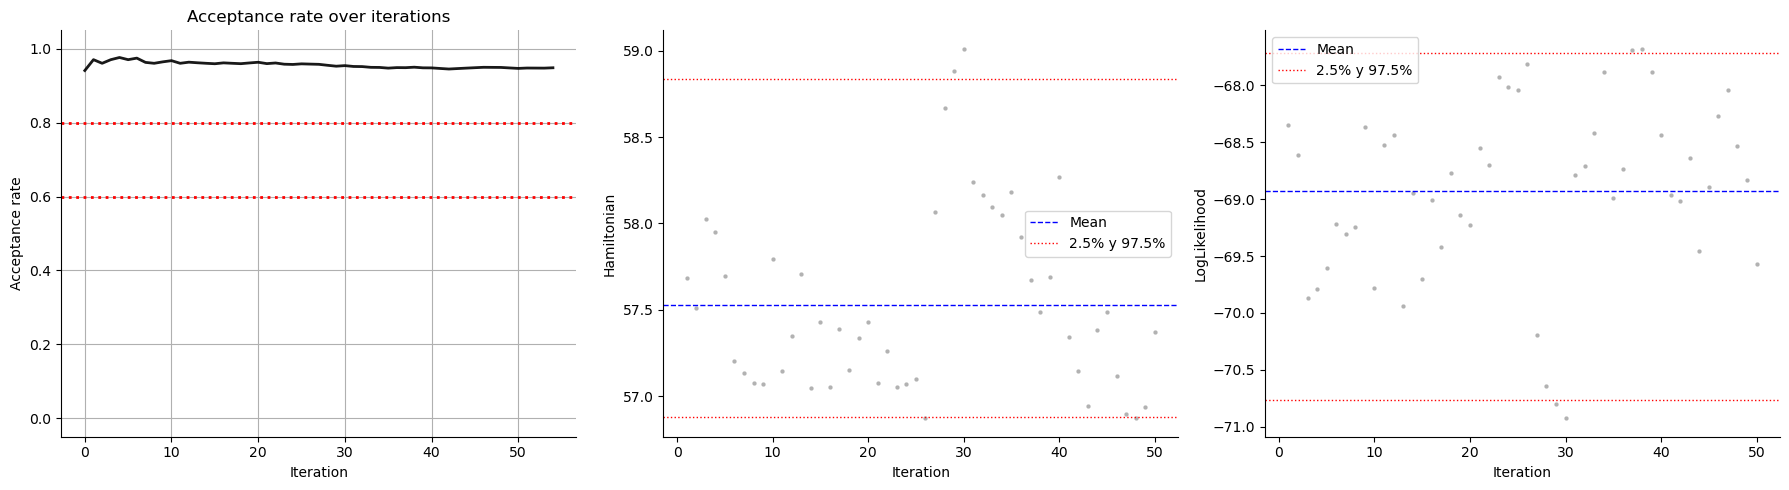

In [9]:
plot_diagnostics(Hp,LogLp,acep_rate_history)

In [13]:
import pandas as pd
import numpy as np

def saving_results(samples, Hamiltonian_p, LogL, acep_rate_history, filename="results.xlsx"):
    samples_Z = samples[0]
    samples_a = samples[1]
    samples_b = samples[2] if len(samples) > 2 else None

    with pd.ExcelWriter(filename, engine="openpyxl") as writer:
        print("Saving samples...")

        reshaped_Z = samples_Z.reshape(samples_Z.shape[0] * samples_Z.shape[1], samples_Z.shape[2])
        df_Z = pd.DataFrame(reshaped_Z)
        df_Z.to_excel(writer, sheet_name="samples_Z", index=False)

        # samples_a
        df_a = pd.DataFrame(samples_a, columns=["a"])
        df_a.to_excel(writer, sheet_name="samples_a", index=False)

        # samples_b 
        if samples_b is not None:
            samples_b = np.array(samples_b)
            if samples_b.ndim == 1:
                df_b = pd.DataFrame(samples_b, columns=["b"])
            else:
                df_b = pd.DataFrame(samples_b)
            df_b.to_excel(writer, sheet_name="samples_b", index=False)

        print("Saving diagnostics...")

        pd.DataFrame(Hamiltonian_p, columns=["Hamiltonian"]).to_excel(writer, sheet_name="Hamiltonian", index=False)
        pd.DataFrame(LogL, columns=["LogLikelihood"]).to_excel(writer, sheet_name="LogL", index=False)
        pd.DataFrame(acep_rate_history, columns=["AcceptanceRate"]).to_excel(writer, sheet_name="AcceptanceRate", index=False)

    print(f"Results saved to {filename}")


In [14]:
saving_results((samples_Z, samples_a, samples_b), Hp, LogLp, acep_rate_history, filename="resultados_ghmc.xlsx")

Saving samples...
Saving diagnostics...
Results saved to resultados_ghmc.xlsx


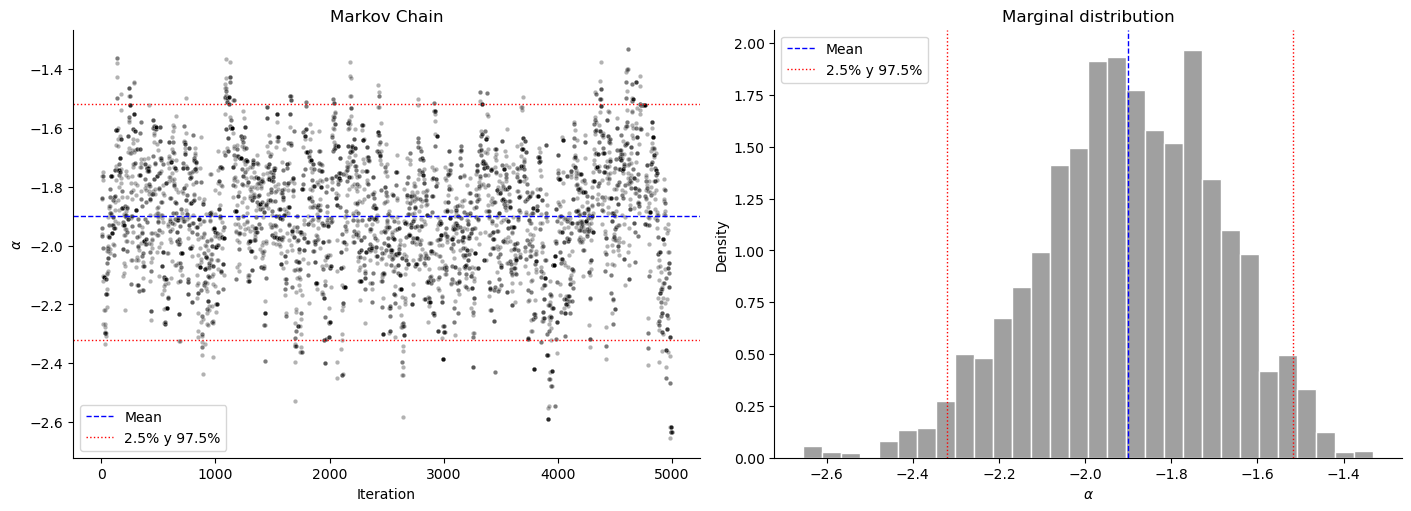

In [20]:
plot_alpha(samples_a)

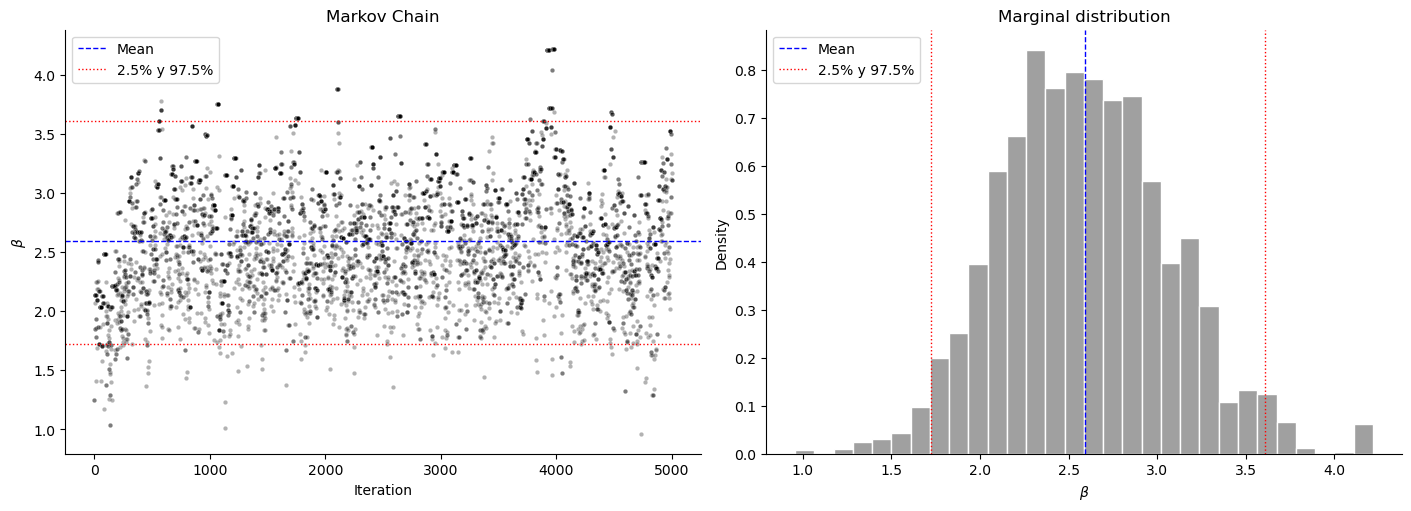

In [21]:
plot_beta(samples_b)

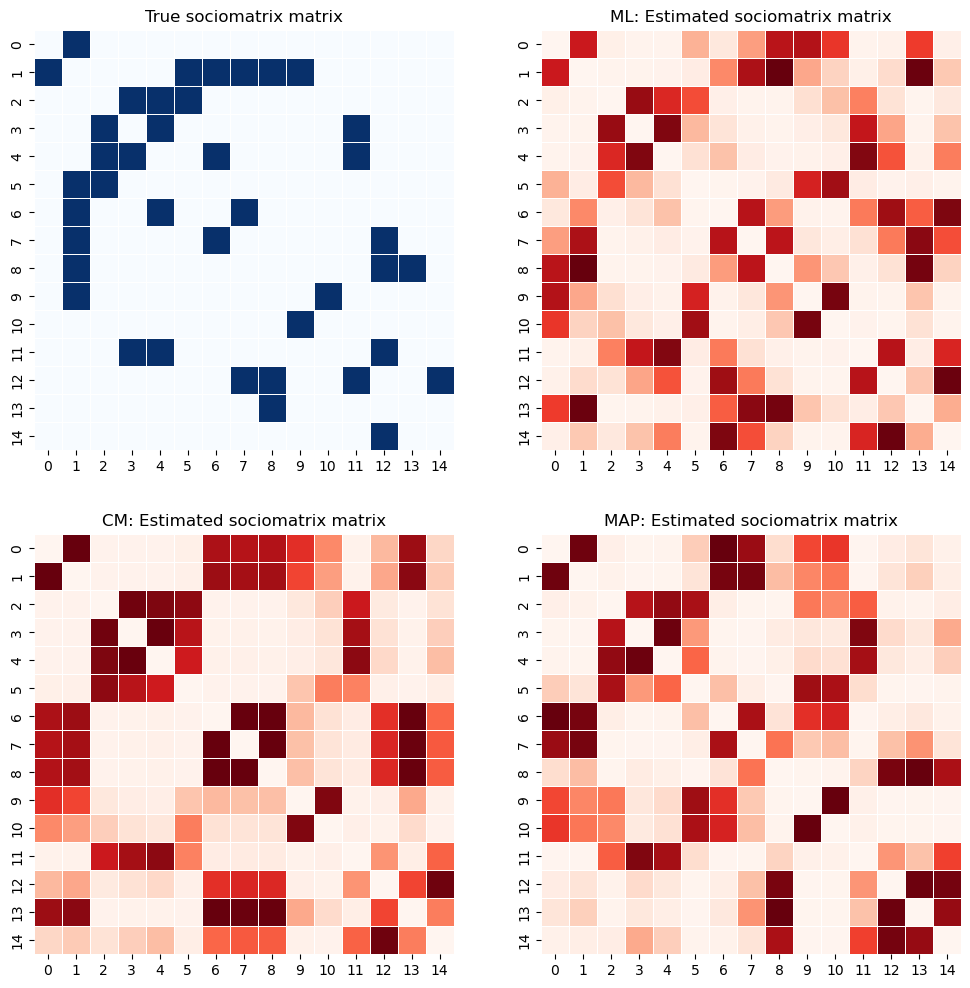

In [22]:
Y_CM = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            dist = Z_CM[i].T @ Z_CM[j]
            Y_CM[i,j] = expit(a_CM + b_CM * dist)

Y_MAP = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            dist = Z_MAP[i].T @ Z_MAP[j]
            Y_MAP[i,j] = expit(a_MAP + b_MAP * dist)

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(2,2,2)
sns.heatmap(Y_ML, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("ML: Estimated sociomatrix matrix")
plt.subplot(2,2,3)
sns.heatmap(Y_CM, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("CM: Estimated sociomatrix matrix")
plt.subplot(2,2,4)
sns.heatmap(Y_MAP, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("MAP: Estimated sociomatrix matrix")
plt.show()

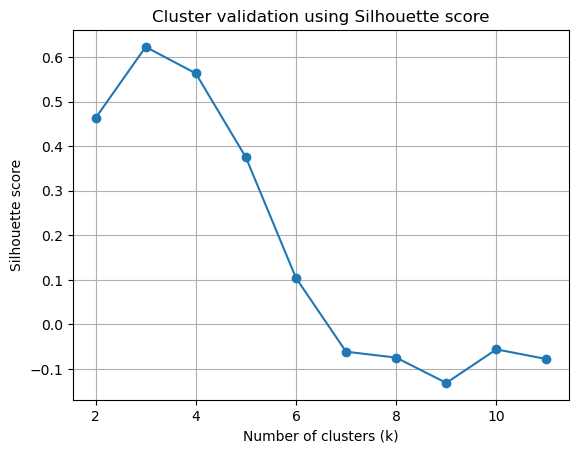

Best number of clusters: 3


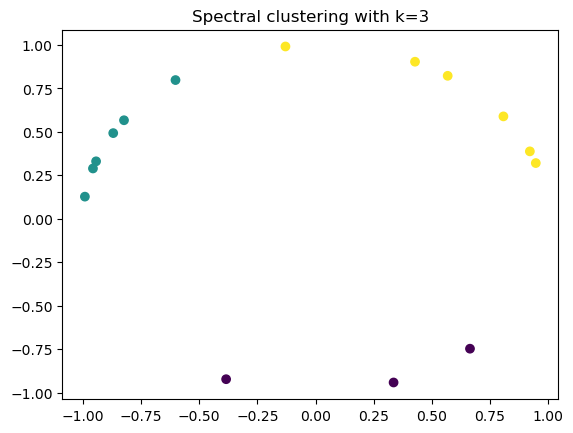

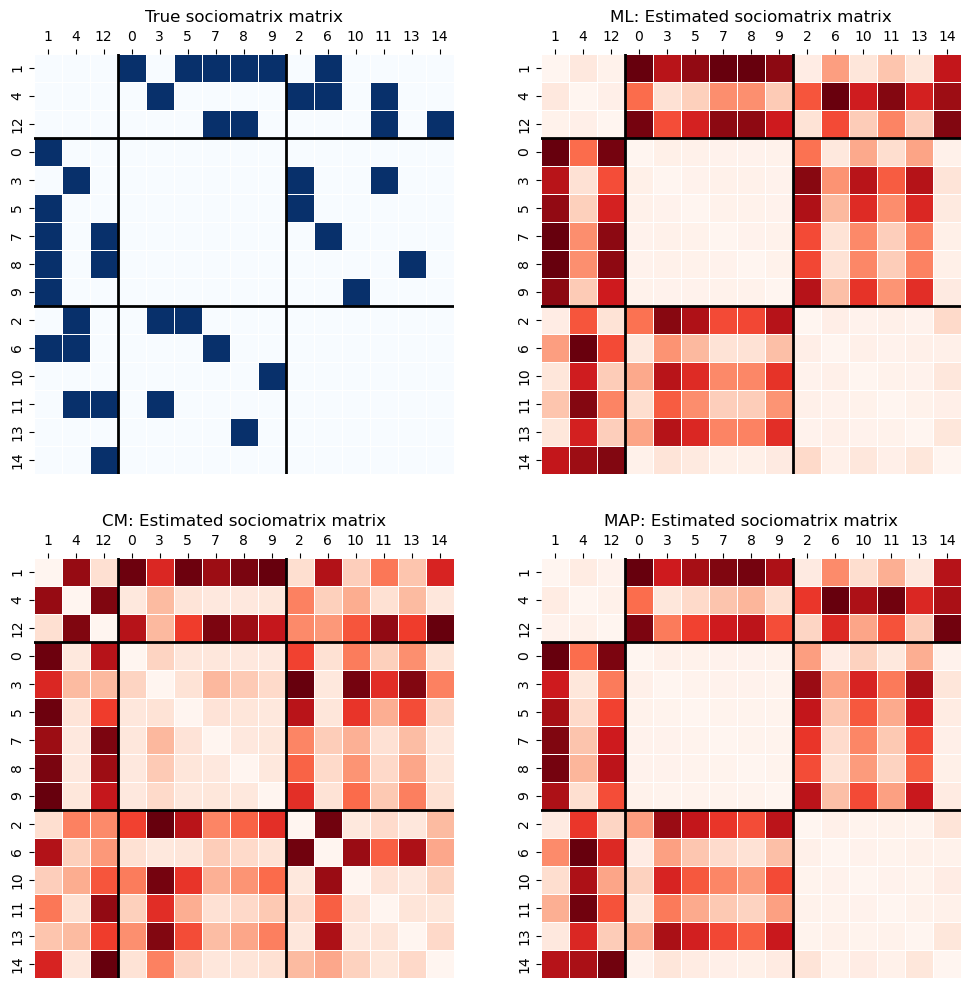

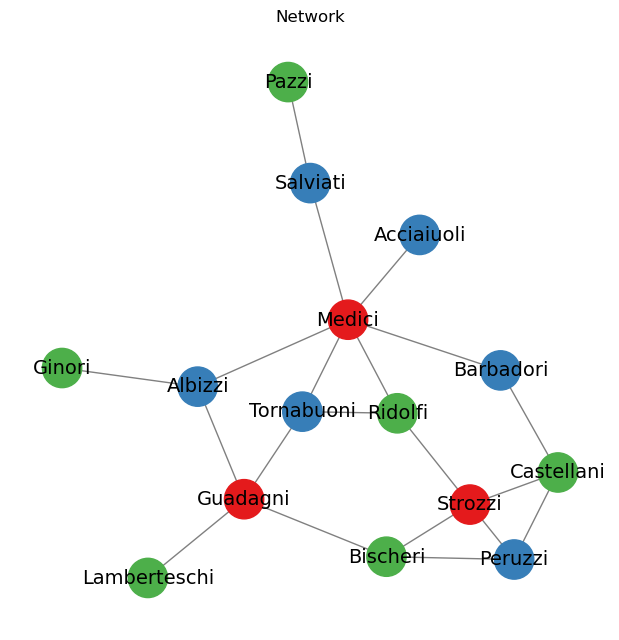

In [26]:
clusteringS1(G,node_mapping, Z_ML, a_ML, b_ML, Z_MAP, a_MAP, b_MAP, Z_CM, a_CM, b_CM)

## Model checking

### Posterior predicitive checking

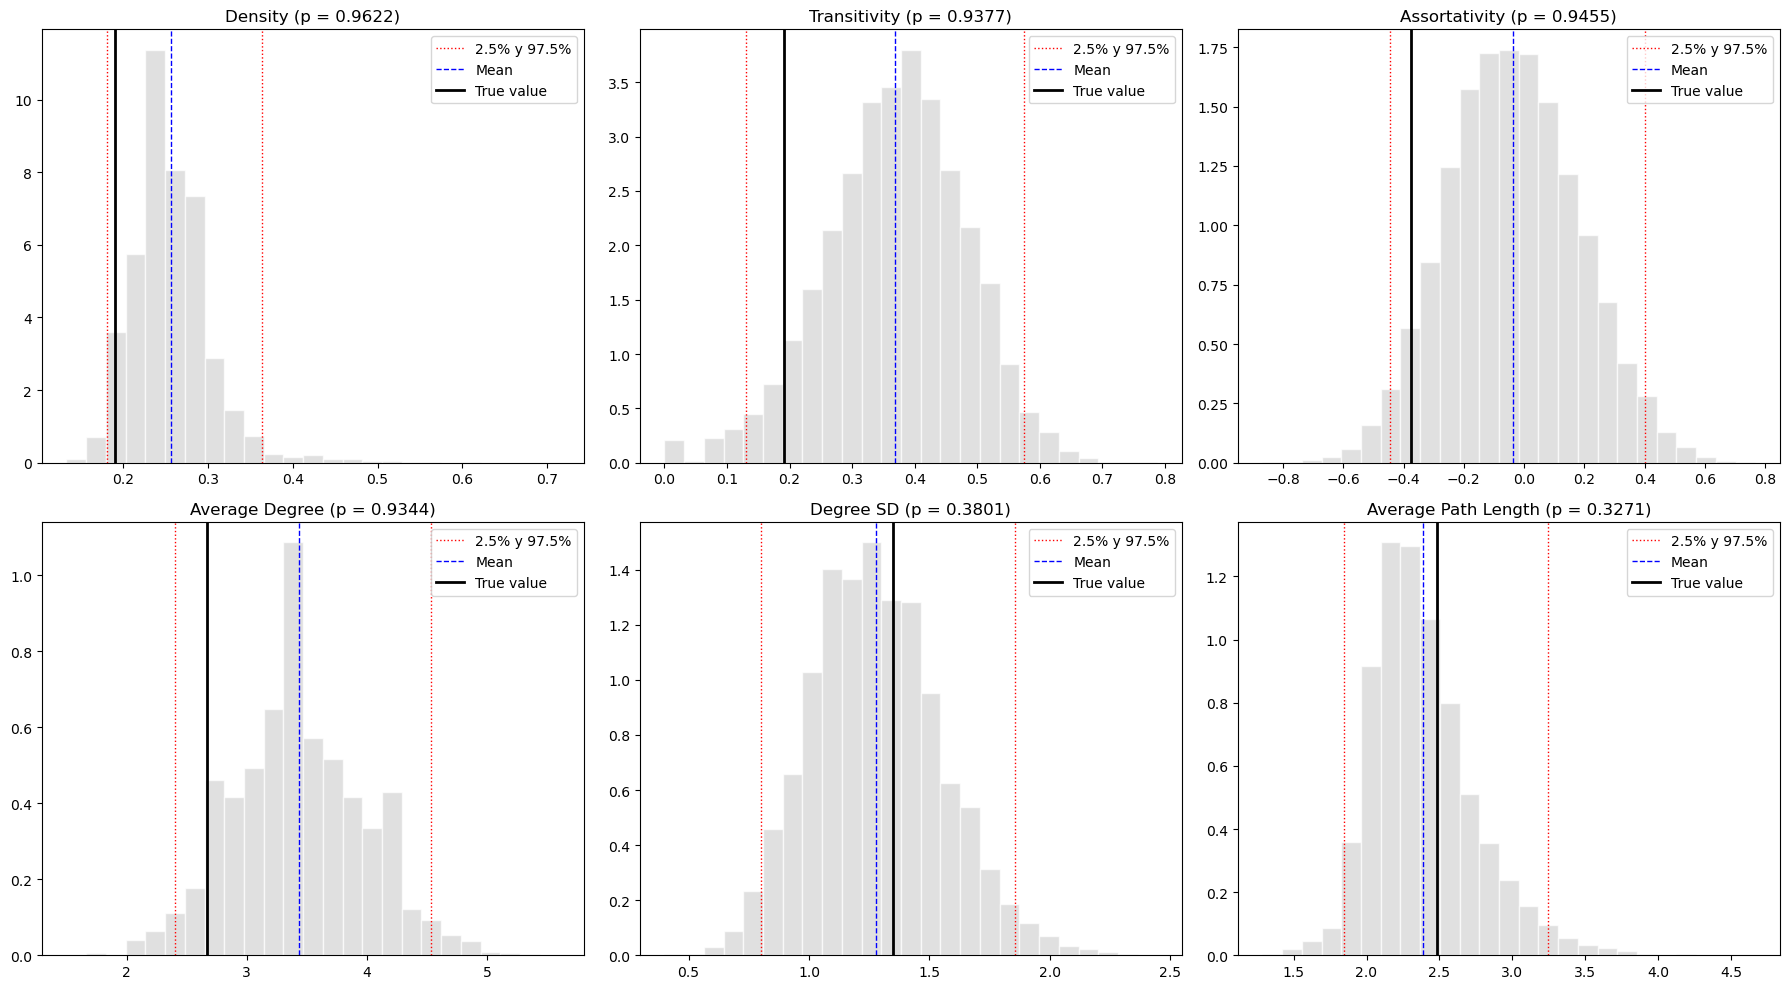

In [16]:
predictive_check(G,samples_Z,samples_a,samples_b)

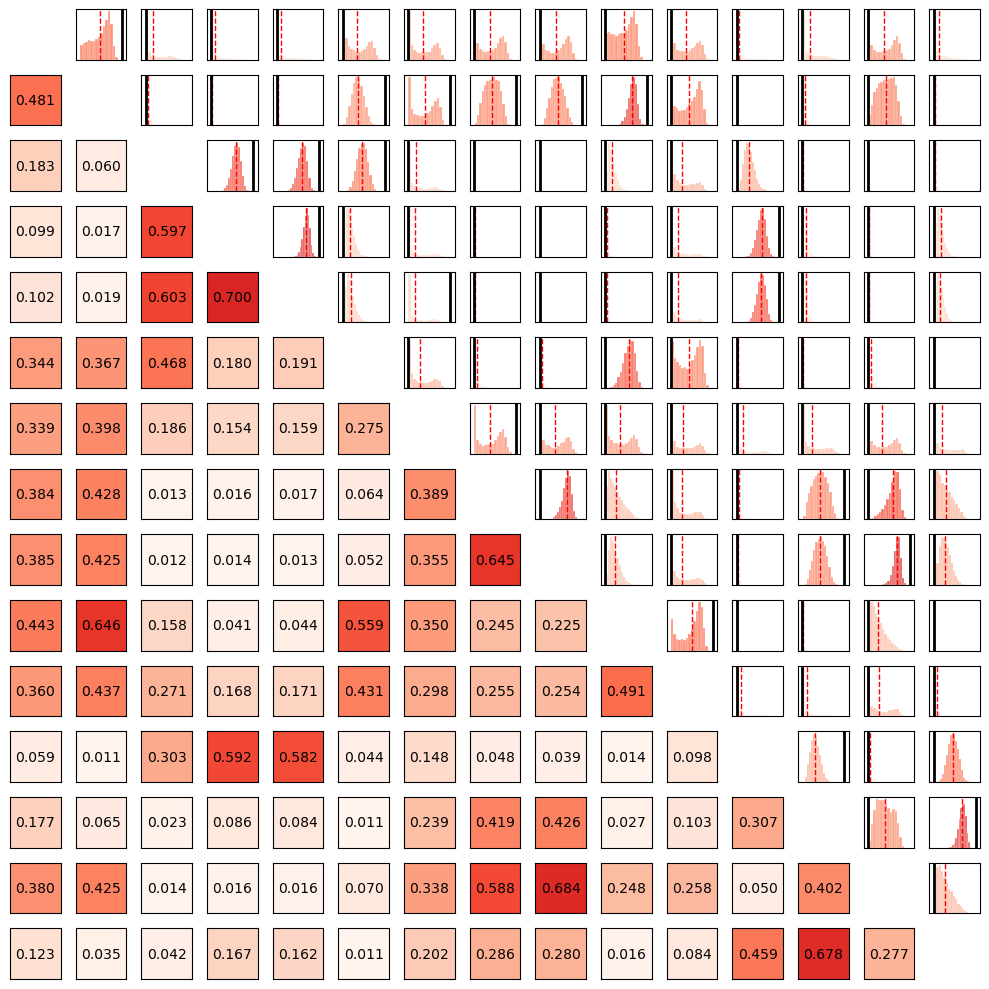

In [17]:
plot_pairwise_sociomatrix(G,samples_Z, samples_a, samples_b, Y)

### Model comparison criteria

In [18]:
log_lik = compute_log_likelihood(Y, samples_Z, samples_a, samples_b)
waic = compute_WAIC(log_lik)
dic = compute_DIC_S1(log_lik, Y, samples_Z, samples_a, samples_b)


print(f"WAIC: {waic:.4f}")
print(f"DIC: {dic:.4f}")

WAIC: 203.4185
DIC: 174.2438


### Prior predictive checks

In [19]:
angles_prior = 2*np.pi*np.random.rand(number_of_samples, n)

samples_Z_prior = np.stack((np.cos(angles_prior), np.sin(angles_prior)), axis=2)
samples_a_prior = np.random.randn(number_of_samples)
samples_b_prior = np.random.randn(number_of_samples)

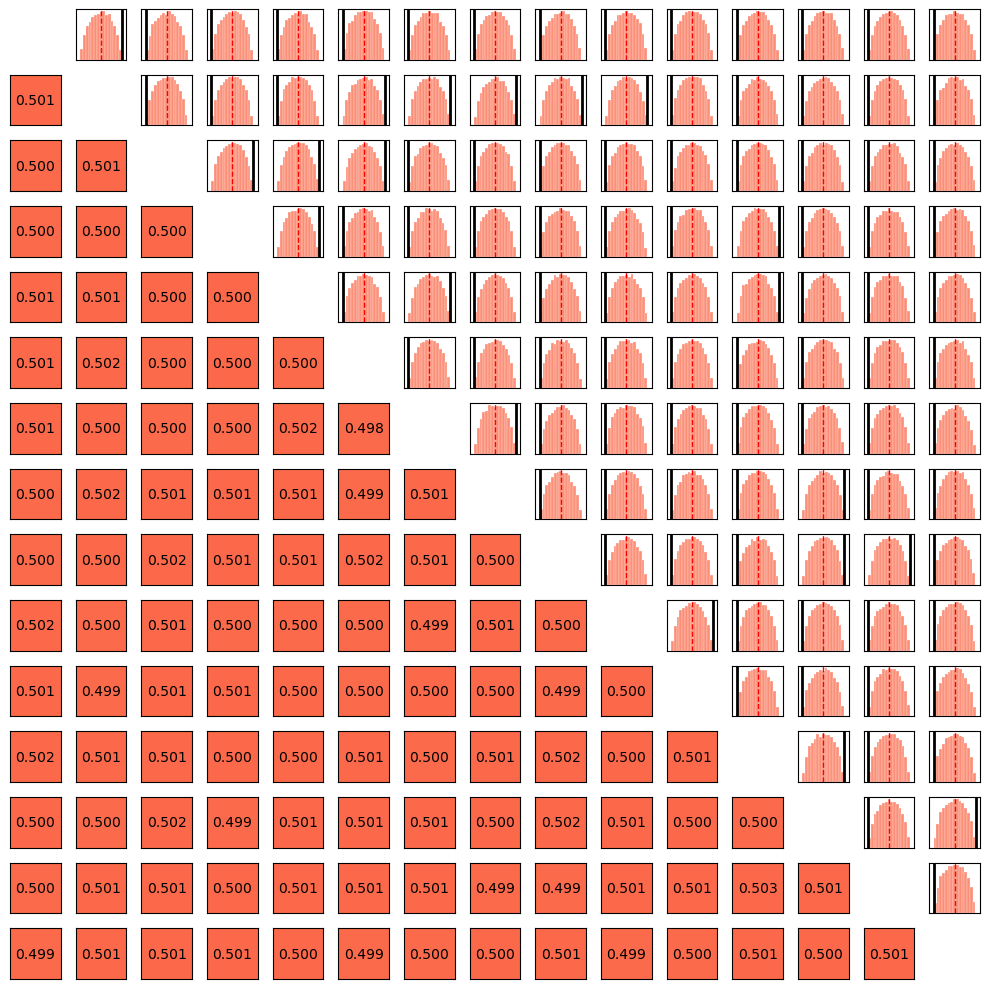

In [21]:
plot_pairwise_sociomatrix(G,samples_Z_prior, samples_a_prior, samples_b_prior, Y)

### Prediction evaluation

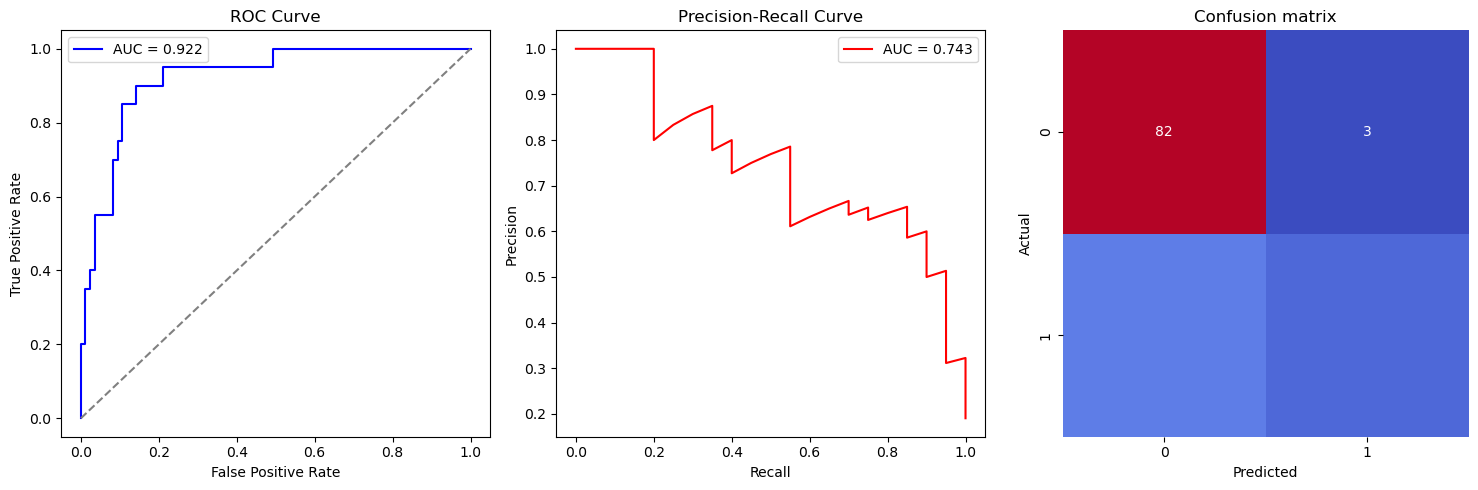

In [26]:
prob_mean = posterior_connection_probs(samples_Z, samples_a, samples_b)
metrics = roc_prc_analysis(Y, prob_mean)


### Community checking

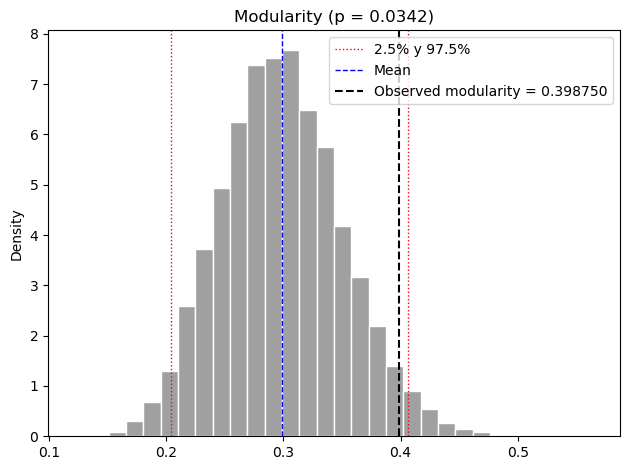

In [27]:
mod_obs, mod_sim = modularity_check(Y, samples_Z, samples_a, samples_b)